<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/denoising/blob/main/figs/averaging_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/denoising/blob/main/figs/averae_denoising.ipynb)

# Denoising using averaging
By simulation, we check that the arithmetic mean (averaging) of several instances of the same noisy signal (*averaging*) approximates to the clean signal. 1D and 2D cases are analyzed. Signal-independent and signal-dependent noise cases are considered.

Notation:

* $X=\text{clean signal.}$
* $N=\text{noise.}$
* $Y=\text{noisy signal.}$ In general, $Y=f(X,N).$

All simulations check that
\begin{equation}
  {\mathbb A}_I(Y)\approx X,
\end{equation}
for a large enough number $I$ of $Y$ instances.

<!-- We measure the performance of averaging considering that, theoretically, the SNR should increase with $\sqrt{I}$, where $I$ is the number of averaged noisy instances. Equivalently, averaging should reduce the noise variance by a factor of $I$, i.e.
\begin{equation}
\sigma^2_{\mathrm averaged}=\frac{\sigma^2_{\mathrm original}}{I},
\end{equation}
although this is not checked.-->

In [1]:
import math
from collections import namedtuple

try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker

try:
    import cv2
except:
    !pip install cv2
    import cv2
    
try:
    from skimage import io as skimage_io
except:
    !pip install scikit-image
    from skimage import io as skimage_io

try:
    import information_theory as IT
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    import information_theory as IT

# apt install cm-super-minimal
# apt install dvipng
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Helvetica",
    "font.family": "Serif",
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amsfonts}"
})
#rc('text', usetex=True)
#rc('font', family='serif')
#plt.rc('text.latex', preamble=r'\usepackage{amsmath} `...')
#mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amsfonts}'

### barb

In [2]:
Args = namedtuple("args", "input")
args = Args("http://www.hpca.ual.es/~vruiz/images/barb.png")

In [3]:
image = skimage_io.imread(args.input)  # Ground Truth
image.mean()

np.float64(112.4467544555664)

In [4]:
image.dtype

dtype('uint8')

In [5]:
#image = 255 * ((image - np.min(image)) / (np.max(image) - np.min(image)))

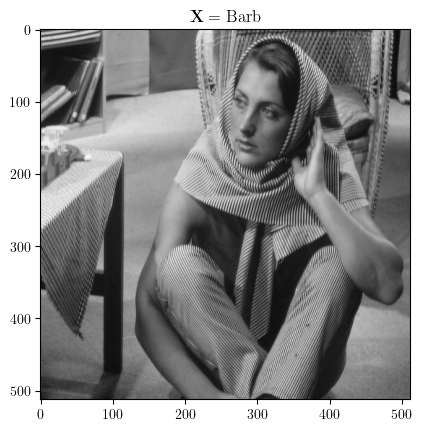

In [6]:
plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
plt.imshow(image, cmap="gray")
#plt.show()
plt.savefig('barb.pdf', bbox_inches='tight')

In [7]:
#mean = np.mean(image)
#zero_mean_image = image.astype(np.float32) - mean
#print(np.mean(zero_mean_image))

In [8]:
min_PSNR = 60  # Minimum quality to stop averaging

## Zero-mean additive Gaussian (ZMAG) noise
\begin{equation}
  Y = X + N,~N\sim{\mathcal N}(\mu=0, \sigma).
\end{equation}

### 1D

In [9]:
X = np.arange(101) - 50
X.mean()

np.float64(0.0)

In [10]:
N = np.random.normal(loc=0, scale=10, size=X.size)
N.mean()

np.float64(0.26422537173486565)

In [11]:
Y = X + N

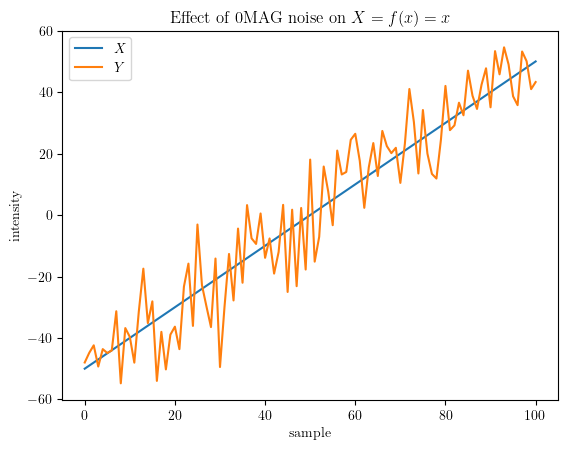

In [12]:
plt.title("Effect of 0MAG noise on $X=f(x)=x$")
plt.plot(X, label="$X$")
plt.plot(Y, label="$Y$")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

In [13]:
X = np.arange(101) - 50
sigma = 10
iters = 100
acc_Y = np.zeros_like(X)
min_Y = np.ones_like(X) * 1000
max_Y = -np.ones_like(X) * 1000
for i in range(iters):
    N = np.random.normal(loc=0, scale=sigma, size=len(X))
    Y = X + N
    min_Y = np.minimum(Y, min_Y)
    max_Y = np.maximum(Y, max_Y)
    acc_Y = acc_Y + Y
average_Y = acc_Y / (i + 1)

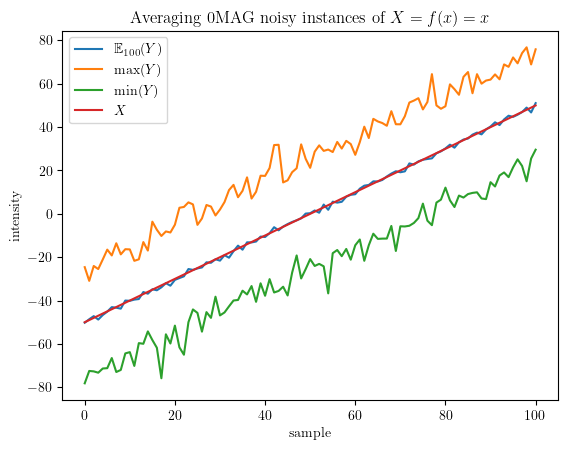

In [14]:
plt.title("Averaging 0MAG noisy instances of $X=f(x)=x$")
plt.plot(average_Y, label=rf"$\mathbb{{E}}_{{\text{{{iters}}}}}(Y)$")
plt.plot(max_Y, label="max($Y$)")
plt.plot(min_Y, label="min($Y$)")
plt.plot(X, label="$X$")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

### 2D

#### 0MAGN_barb

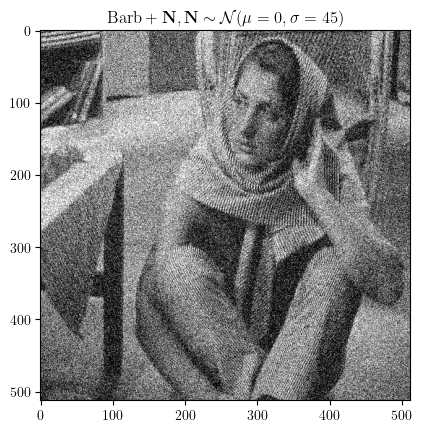

In [15]:
std_dev = 45
plt.title(r"$\mathrm{Barb} + \mathbf{N}, \mathbf{N}\sim \mathcal{N}" + rf"(\mu=0, \sigma={std_dev})$")
Y = image + np.random.normal(loc=0, scale=std_dev, size=image.shape).reshape(image.shape)
Y = np.clip(a = Y, a_min=0, a_max=255)
plt.imshow(Y, cmap="gray")
plt.savefig('0MAGN_barb.pdf', bbox_inches='tight')

#### averaging_0MAGN_barb

In [16]:
X = image
curves = []
#sigma_index = 1
for std_dev in range(10, 50, 5):
    acc_denoised = np.zeros_like(X, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        N = np.random.normal(loc=0, scale=std_dev, size=X.shape).reshape(X.shape)
        Y = X.astype(np.float32) + N
        Y = np.clip(a=Y, a_min=0, a_max=255).astype(np.uint8)
        acc_denoised += Y
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised, X)
        print(std_dev, iters, PSNR)
        curve.append(PSNR)
        iters += 1
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    #sigma_index += 1
    print()

10 1 63.33354522898731

15 1 55.29635319279379
15 2 62.2054242832721

20 1 49.57715111695407
20 2 56.50907947145123
20 3 60.549926888942515

25 1 45.25852227138553
25 2 52.163748422786334
25 3 56.221248920353204
25 4 59.07039857860209
25 5 61.31017810116318

30 1 41.76300700545121
30 2 48.66269693330124
30 3 52.72338401983481
30 4 55.57302732377067
30 5 57.78470591195532
30 6 59.59973592197058
30 7 61.13875199983692

35 1 38.81921161755517
35 2 45.73370075678923
35 3 49.769681522462
35 4 52.65429946536226
35 5 54.9210603770955
35 6 56.73338496809456
35 7 58.233936575973914
35 8 59.567275500214414
35 9 60.749335640491296

40 1 36.35649421595687
40 2 43.24386190486124
40 3 47.2766007854312
40 4 50.14443870047546
40 5 52.369451301882094
40 6 54.19406771222179
40 7 55.727353383754526
40 8 57.04437106720157
40 9 58.22047650839096
40 10 59.26034406151564
40 11 60.200143756448796

45 1 34.20602452057244
45 2 41.07221226224933
45 3 45.12494898062434
45 4 47.979654972474734
45 5 50.183612025000

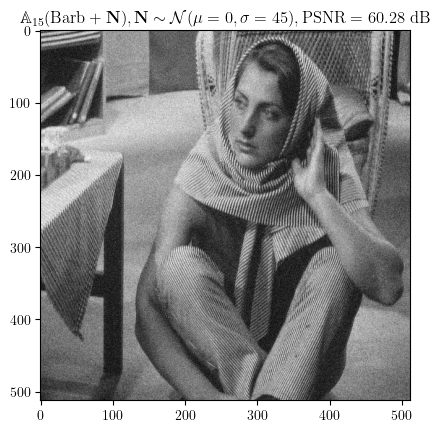

In [17]:
plt.title(r"$\mathbb{A}_{\text{" + str(iters) + r"}}(\mathrm{Barb} + \mathbf{N}), \mathbf{N}\sim \mathcal{N}" + rf"(\mu=0, \sigma={std_dev})," + r"\mathrm{PSNR}=" + f"{PSNR:.2f}" + r"~\mathrm{dB}$")
plt.imshow(denoised, cmap="gray")
plt.savefig('averaging_0MAGN_barb.pdf', bbox_inches='tight')

#### PSNR_averaging_0MAGN_barb

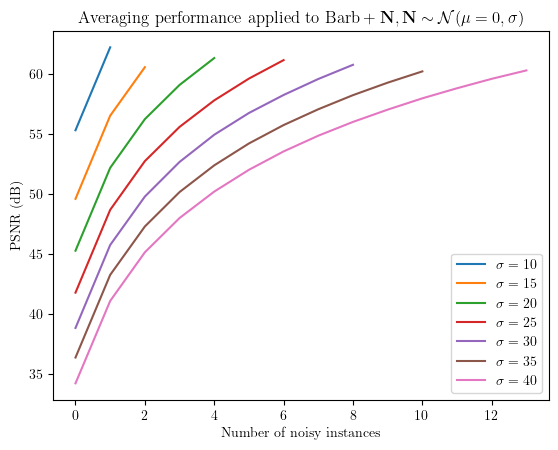

In [18]:
plt.title(r"Averaging performance applied to $\mathrm{Barb} + \mathbf{N}, \mathbf{N}\sim \mathcal{N}(\mu=0, \sigma)$")
for i in range(len(curves)):
    if len(curves[i]) > 1:
        plt.plot(curves[i], label=rf"$\sigma={(i+1)*5}$")
    #print(i)
plt.ylabel(r"PSNR ($\mathrm{dB}$)")
plt.xlabel(r"Number of noisy instances")
plt.legend()
#plt.show()
plt.savefig("PSNR_averaging_0MAGN_barb.pdf", bbox_inches='tight')

## Poisson noise (shot noise)
\begin{equation}
  Y=\frac{N}{\gamma},~N∼\text{Poisson}(λ=\gamma X),
\end{equation}
where:
* $X\ge 0$.
* $\lambda\in{\mathbb R}\ge 0$ is the rate of the Poisson distribution (resulting that $\lambda={\mathbb A}(N)=\text{Var}(N)$.

### 1D

In [19]:
X = np.arange(101)
X.mean()

np.float64(50.0)

In [20]:
_lambda = 0.3
Y = np.random.poisson(X * _lambda) /  _lambda
print(np.mean(Y))

51.68316831683168


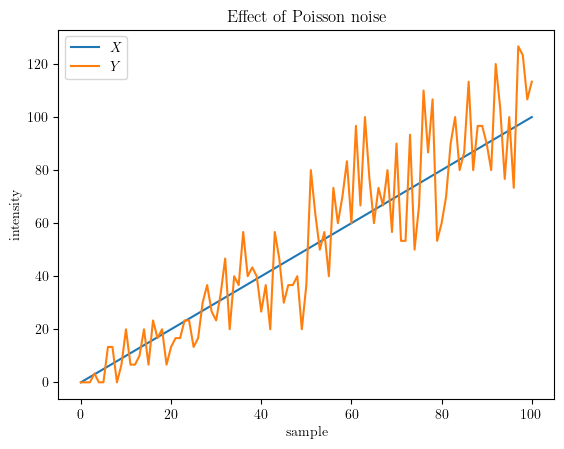

In [21]:
plt.title("Effect of Poisson noise")
plt.plot(X, label="$X$")
plt.plot(Y, label="$Y$")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

In [22]:
X = np.arange(101)
_lambda = 1
iters = 100
acc_Y = np.zeros_like(X)
min_Y = np.ones_like(X) * 1000
max_Y = -np.ones_like(X)
for i in range(iters):
    Y = np.random.poisson(X * _lambda) /  _lambda
    min_Y = np.minimum(Y, min_Y)
    max_Y = np.maximum(Y, max_Y)
    acc_Y = acc_Y + Y
average_Y = acc_Y / (i + 1)

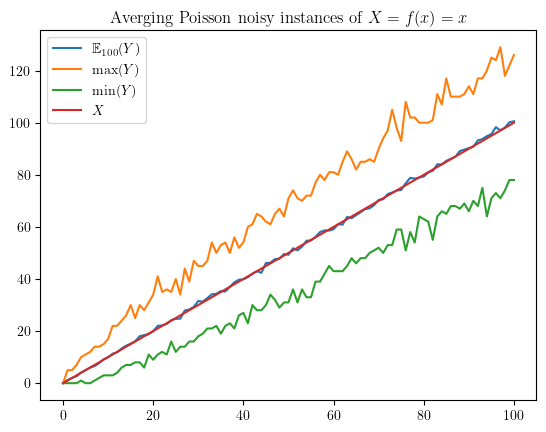

In [23]:
plt.title("Averging Poisson noisy instances of $X=f(x)=x$")
#plt.plot(average_Y, label=r"$\mathbb{A}_{iters}(Y)$")
plt.plot(average_Y, label=rf"$\mathbb{{E}}_{{\text{{{iters}}}}}(Y)$")
#plt.plot(np.random.poisson(X * _lambda) /  _lambda, label="$Y$ (example)")
plt.plot(max_Y, label="max($Y$)")
plt.plot(min_Y, label="min($Y$)")
plt.plot(X, label="$X$")
plt.legend()
plt.show()

### 2D

#### Poisson_barb

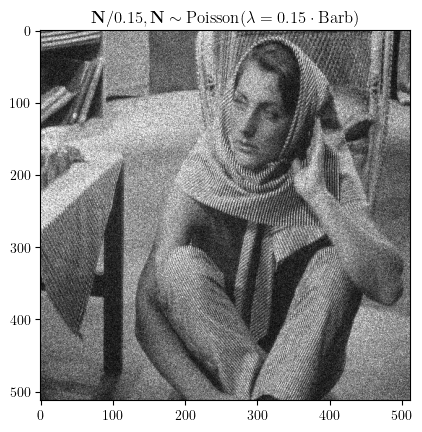

In [24]:
_lambda = 0.15
plt.title(r"$\mathbf{N}" + rf"/{_lambda}" + r", \mathbf{N}\sim\mathrm{Poisson}" + rf"(\lambda={_lambda}" + r"\cdot\mathrm{Barb})$")
Y = np.random.poisson(image.astype(np.float32) * _lambda) / _lambda
Y = np.clip(a = Y, a_min=0, a_max=255)
plt.imshow(Y, cmap="gray")
plt.savefig('Poisson_barb.pdf', bbox_inches='tight')

#### averaging_Poisson_barb

a 324.0 0.0 112.50161743164062
0.25 1 48.403863266594286 255.0 0.0
a 348.0 0.0 112.509521484375
0.25 2 55.38807895324346 255.0 4.0
a 328.0 0.0 112.52349853515625
0.25 3 59.39047293473682 254.0 9.333333333333334
a 356.0 0.0 112.45429992675781
0.25 4 62.28756600540359 253.5 10.0

a 368.88888888888886 0.0 112.4477810329861
0.225 1 47.35382310375521 255.0 0.0
a 333.3333333333333 0.0 112.3951212565104
0.225 2 54.30775380354014 255.0 2.0
a 328.88888888888886 0.0 112.44418674045137
0.225 3 58.32867930258523 255.0 7.0
a 346.6666666666667 0.0 112.46207343207466
0.225 4 61.166781509720984 255.0 7.25

a 385.0 0.0 112.42122650146484
0.2 1 46.28051139189789 255.0 0.0
a 330.0 0.0 112.48558044433594
0.2 2 53.203381638895394 255.0 5.0
a 335.0 0.0 112.49662399291992
0.2 3 57.220627842911 255.0 6.666666666666667
a 360.0 0.0 112.48266220092773
0.2 4 60.093944152691385 255.0 8.75

a 342.8571428571429 0.0 112.44966779436383
0.175 1 44.9406404912513 255.0 0.0
a 371.42857142857144 0.0 112.35382080078124
0.17

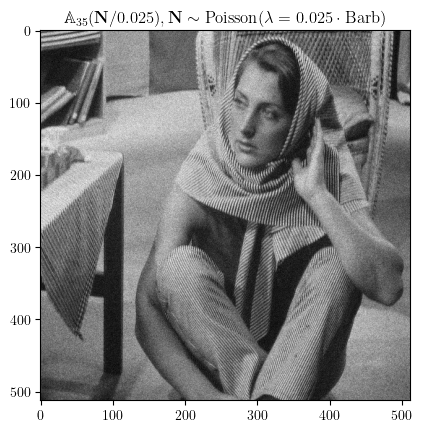

In [25]:
X = image
curves = []
#print(X.max(), X.min(), X.mean())
for _lambda in range(10, 0, -1):
    _lambda /= 40
    acc_denoised = np.zeros_like(X, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        #Y = np.random.poisson((X.astype(np.float32) + 1) * _lambda)
        #Y = Y - _lambda
        Y = np.random.poisson(X.astype(np.float32) * _lambda) / _lambda
        #Y = Y - _lambda
        #Y = Y / _lambda
        print('a', np.max(Y), np.min(Y), np.mean(Y))
        Y = np.clip(a = Y, a_min=0, a_max=255)
        Y = Y.astype(np.uint8)
        #print('b', np.max(Y), np.min(Y))
        acc_denoised += Y
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), X)
        print(_lambda, iters, PSNR, np.max(denoised), np.min(denoised))
        curve.append(PSNR)
        iters += 1
        #print('b', np.mean(denoised))
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    print()

plt.title(r"$\mathbb{A}_{\text{" + str(iters) + r"}}(\mathbf{N}" + rf"/{_lambda}" + r"), \mathbf{N}\sim\mathrm{Poisson}" + rf"(\lambda={_lambda}" + r"\cdot\mathrm{Barb})$")
plt.imshow(denoised, cmap="gray")
plt.savefig('averaging_Poisson_barb.pdf', bbox_inches='tight')

#### PSNR_Poisson_barb

10
9
8
7
6
5
4
3
2
1


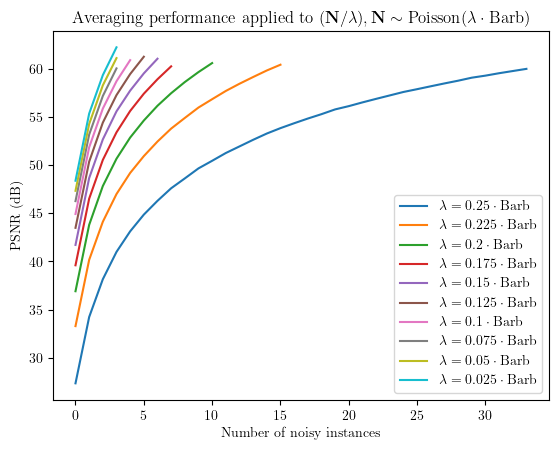

In [26]:
plt.title(r"Averaging performance applied to " + r"$(\mathbf{N}" + r"/\lambda" + r"), \mathbf{N}\sim\mathrm{Poisson}" + rf"(\lambda\cdot" + r"\mathrm{Barb})$")
#plt.title(r"$\mathbb{A}_{\text{" + str(iters) + r"}}(\mathbf{N}" + rf"/{_lambda}" + r"), \mathbf{N}\sim\mathrm{Poisson}" + rf"(\lambda={_lambda}" + r"\mathrm{Barb})$")
#plt.title("Averaging Poisson noisy instances of \"Barb\"")
for i in range(10, 0, -1):
    print(i)
    if len(curves[i-1]) > 1:
        plt.plot(curves[i-1], label=rf"$\lambda={i/40}" + r"\cdot\mathrm{Barb}$")
plt.ylabel(r"PSNR ($\mathrm{dB}$)")
plt.xlabel(r"Number of noisy instances")
plt.legend()
#plt.show()
plt.savefig("PSNR_Poisson_barb.pdf", bbox_inches='tight')

## Mixed Poisson-Gaussian (MPG) noise
\begin{equation}
  Y = \gamma N_{{\mathrm Poisson}}(X) + N_{{\mathrm Gaussian}}
\end{equation}
$N_{{\mathrm Gaussian}}\sim{\mathcal N}(\mu=0, \sigma^2), N_{{\mathrm Poisson}}\sim{\mathcal P}(\lambda=\gamma X)$.

In [27]:
def __MPG_noise(X, std_dev=10.0, gamma=0.1, poisson_ratio=0.5):
    N_poisson = np.random.poisson(X * gamma)/gamma
    N_gaussian = np.random.normal(loc=0, scale=std_dev, size=X.size)
    N_gaussian = np.reshape(N_gaussian, X.shape)
    #print("std_dev=", std_dev)
    #print("gamma=", gamma)
    #print("poisson_gain=", poisson_gain)
    #print("X=", np.min(X), np.max(X))
    #print("N_gaussian=", np.min(N_gaussian), np.max(N_gaussian))
    #print("N_poisson=", np.min(N_poisson), np.max(N_poisson))
    Y = N_gaussian + N_poisson
    #Y = (1 - poisson_gain) * (X.astype(np.float32) + N_gaussian) + poisson_gain * N_poisson
    #Y = 255 * ((Y - np.min(Y)) / (np.max(Y) - np.min(Y) ))
    #print("Y=", np.min(Y), np.max(Y))
    #Y = N_gaussian + gamma*N_poisson
    #Y = N_poisson
    #Y = N_gaussian + X
    return Y

def MPG_noise(X, std_dev=10.0, gamma=0.1, poisson_ratio=0.5):
    N_gaussian = np.random.normal(loc=0, scale=std_dev, size=X.size).reshape(X.shape)
    #N_gaussian = np.clip(N_gaussian, 0, 255)
    N_poisson = np.random.poisson(X * gamma)/gamma
    #N_poisson = np.clip(N_poisson, 0, 255)
    #N_poisson = np.random.poisson(X)
    #print("std_dev=", std_dev)
    #print("gamma=", gamma)
    #print("poisson_ratio=", poisson_ratio)
    #print("X=", np.min(X), np.max(X))
    #print("N_gaussian=", np.min(N_gaussian), np.max(N_gaussian))
    #print("N_poisson=", np.min(N_poisson), np.max(N_poisson))
    Y = (1 - poisson_ratio) * (X + N_gaussian) + poisson_ratio * N_poisson
    #Y = (1 - poisson_ratio) * ( N_gaussian) + poisson_ratio * N_poisson
    Y = np.clip(Y, 0, 255)
    #Y = 255 * ((Y - np.min(Y)) / (np.max(Y) - np.min(Y) ))
    #print("Y=", np.min(Y), np.max(Y))
    #Y = N_gaussian + gamma*N_poisson
    #Y = N_poisson
    #Y = N_gaussian + X
    return Y

In [28]:
x = np.full(20, 1000)
np.random.poisson(x)

array([ 974, 1074,  990, 1019, 1027, 1037, 1022,  999, 1009, 1006,  979,
       1015,  967,  957,  970,  987,  962,  961, 1011,  969])

### 1D

In [29]:
X = np.arange(101)

In [30]:
gamma = 1.0
std_dev = 10
#N_poisson = np.random.poisson(X * _lambda) /  _lambda
#N_gaussian = np.random.normal(loc=0, scale=10, size=X.size)
Y = MPG_noise(X, std_dev, gamma)
print(np.mean(Y))

49.49820009955335


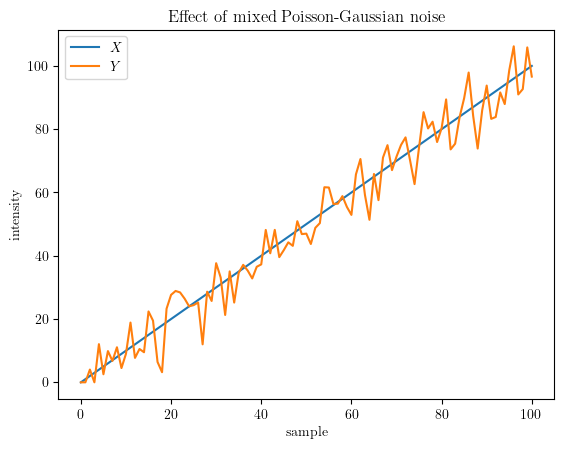

In [31]:
plt.title("Effect of mixed Poisson-Gaussian noise")
plt.plot(X, label="$X$")
plt.plot(Y, label="$Y$")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

In [32]:
X = np.arange(101)
gamma = 0.5
iters = 100
acc_Y = np.zeros_like(X)
min_Y = np.ones_like(X) * 1000
max_Y = -np.ones_like(X)
for i in range(iters):
    Y = MPG_noise(X, std_dev, gamma)
    min_Y = np.minimum(Y, min_Y)
    max_Y = np.maximum(Y, max_Y)
    acc_Y = acc_Y + Y
average_Y = acc_Y / (i + 1)

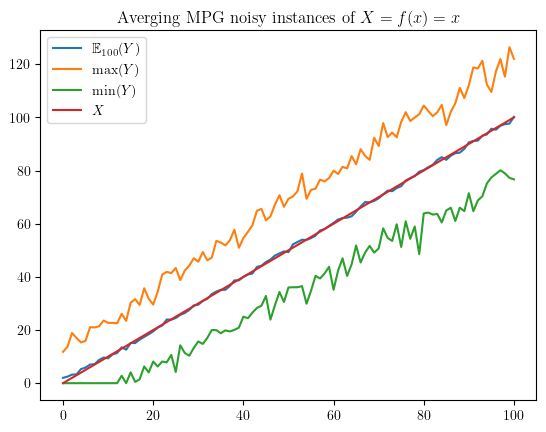

In [33]:
plt.title("Averging MPG noisy instances of $X=f(x)=x$")
plt.plot(average_Y, label=rf"$\mathbb{{E}}_{{\text{{{iters}}}}}(Y)$")
plt.plot(max_Y, label="max($Y$)")
plt.plot(min_Y, label="min($Y$)")
plt.plot(X, label="$X$")
plt.legend()
plt.show()

### 2D

#### 0MMPG_barb

min(image)= 14
max(image)= 238
aqui 255.0 0.0


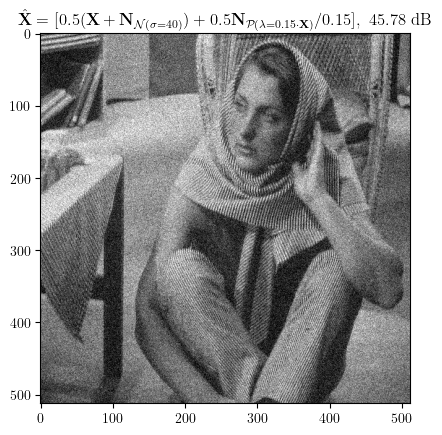

In [34]:
gamma = 0.15 # 0.15
std_dev = 40 # 30

Y = MPG_noise(image, std_dev, gamma, poisson_ratio=0.5).reshape(image.shape)
#Y = np.random.poisson(image.astype(np.float32) * _lambda) / _lambda

string  = r'$\hat{\mathbf{X}}=['
string += r"0.5(\mathbf{X} + \mathbf{N}_{\mathcal{N}"
string += r"(\sigma"
string += f"={std_dev})"
string += r'}'
string += r") + 0.5\mathbf{N}_{\mathcal{P}"
string += r"(\lambda"
string += f"={gamma}"
string += r'\cdot\mathbf{X})}'
string += f"/{gamma}"
string += ']'

string += f",~{IT.distortion.PSNR(Y.astype(np.uint8), image):.2f}"
string += r"~\text{dB}$"

plt.title(string)
print("min(image)=", np.min(image))
print("max(image)=", np.max(image))
#+ rf"$_(\sigma^2={std_dev})$") #" #+ \mathbf{N}_{{\mathcal P}(\lambda=\gamma\cdot\mathrm{Barb})}/\gamma$") 
print("aqui", np.max(Y), np.min(Y))
#Y = np.clip(a = Y, a_min=0, a_max=255)
plt.imshow(Y, cmap="gray")
plt.savefig('0MMPG_barb.pdf', bbox_inches='tight')

#### averaging_0MMPG_barb

In [35]:
X = image
curves = []
for std_dev in range(0, 100, 20):
    gamma = 0.15 # std_dev / 100
    acc_denoised = np.zeros_like(X, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        #Y = np.random.poisson((X.astype(np.float32) + 1) * _lambda)
        #Y = Y - _lambda
        Y = MPG_noise(X, std_dev, gamma)
        #Y = Y - _lambda
        #Y = Y / _lambda
        print('a', np.max(Y), np.min(Y), np.mean(Y))
        Y = np.clip(a = Y, a_min=0, a_max=255)
        Y = Y.astype(np.uint8)
        #print('b', np.max(Y), np.min(Y))
        acc_denoised += Y
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), X)
        print(_lambda, iters, PSNR, np.max(denoised), np.min(denoised))
        curve.append(PSNR)
        iters += 1
        #print('b', np.mean(denoised))
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    print(iters)

a 255.0 10.5 112.44289271036784
0.025 1 57.11814629932117 255.0 10.0
a 255.0 9.5 112.43971125284831
0.025 2 63.965455072926545 255.0 13.0
3
a 255.0 0.0 112.4920138151217
0.025 1 52.812261367946206 255.0 0.0
a 255.0 0.0 112.47058666892637
0.025 2 59.754163871283794 255.0 2.0
a 255.0 0.0 112.46135382985773
0.025 3 63.76473362084464 255.0 5.0
4
a 255.0 0.0 112.49554898417456
0.025 1 45.80872507629423 255.0 0.0
a 255.0 0.0 112.47346967409568
0.025 2 52.73319786469713 255.0 0.0
a 255.0 0.0 112.44694968164758
0.025 3 56.78268467715802 255.0 0.0
a 255.0 0.0 112.51002428353542
0.025 4 59.62745130879047 252.75 1.25
a 255.0 0.0 112.47518230702292
0.025 5 61.82856922129968 250.8 1.2
6
a 255.0 0.0 112.56635177980019
0.025 1 39.908212563723936 255.0 0.0
a 255.0 0.0 112.64536478402198
0.025 2 46.81452130245571 255.0 0.0
a 255.0 0.0 112.66322096020403
0.025 3 50.87257839695077 255.0 0.0
a 255.0 0.0 112.65645037153872
0.025 4 53.745275749029766 255.0 0.0
a 255.0 0.0 112.53644201917592
0.025 5 55.96656

In [36]:
# Special case for displaying

gamma = 0.15
std_dev = 40
acc_denoised = np.zeros_like(X, dtype=np.float64)
iters = 1
PSNR = 1
while PSNR < min_PSNR:
    Y = MPG_noise(X, std_dev, gamma)
    #Y = np.clip(a = Y, a_min=0, a_max=255)
    Y = Y.astype(np.uint8)
    acc_denoised += Y
    denoised = acc_denoised/iters
    PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), X)
    iters += 1

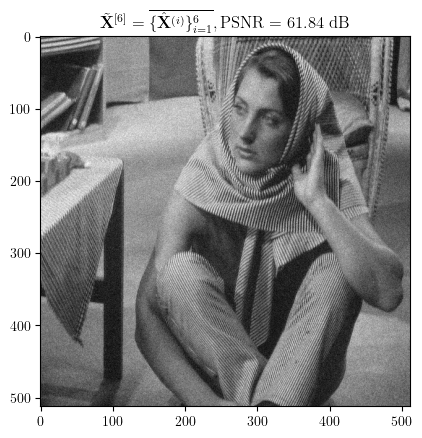

In [37]:
#plt.title(r"$\mathbb{A}_{\text{" + str(iters) + r"}}(\mathbf{N}" + rf"/{_lambda}" + r"), \mathbf{N}\sim\mathrm{Poisson}" + rf"(\lambda={_lambda}" + r"\cdot\mathrm{Barb})$")
string  = r"$\tilde{\mathbf{X}}"
string += r"^{[" + str(iters) + r"]}"
string += r"=\overline{\{\hat{\mathbf{X}}^{(i)}\}_{i=1}^{"
string += str(iters)
string += r"}}, \text{PSNR}="
string += f"{IT.distortion.PSNR(denoised.astype(np.uint8), X):.2f}"
string += r"~\text{dB}$"
plt.title(string)
plt.imshow(denoised, cmap="gray")
plt.savefig('averaging_0MMPG_barb.pdf', bbox_inches='tight')

#### PSNR_averaging_0MMPG_barb

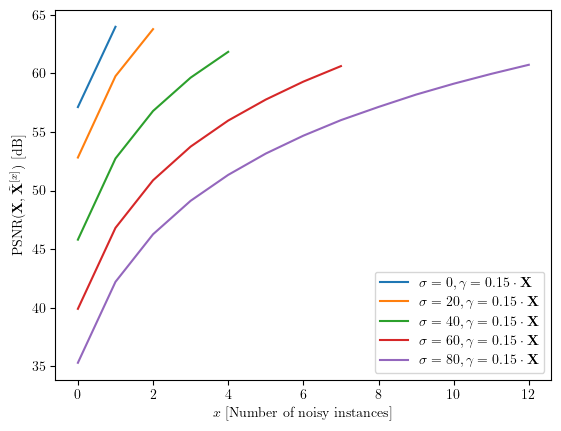

In [39]:
string  = r'$\mathbb{A}_x['
string += r"\mathrm{Barb} + \mathbf{N}_{\mathcal{N}"
string += r"(\sigma)"
string += r'}'
string += r" + \mathbf{N}_{\mathcal{P}"
string += r"(\lambda)}]"
#string += r'\cdot\mathrm{Barb})})'
#string += rf"$_{(\sigma^2={std_dev}^2)}$"
string += '$'
#plt.title(string)
#plt.title(r"$\mathbb{A}_{\text{" + str(iters) + r"}}(\mathbf{N}" + rf"/{_lambda}" + r"), \mathbf{N}\sim\mathrm{Poisson}" + rf"(\lambda={_lambda}" + r"\mathrm{Barb})$")
#plt.title("Averaging Poisson noisy instances of \"Barb\"")
#for i in range(1, 50, 5):
i = 0
for std_dev in range(0, 100, 20):
    #if len(curves[int(i/5)-1]) > 1:
        #plt.plot(curves[int(i/5)-1], label=rf"$\sigma={i}, \lambda={i/50}" + r"\cdot\mathbf{X}$")
    plt.plot(
        curves[i],
        label=rf"$\sigma={std_dev}, \gamma={gamma}"
        + r"\cdot\mathbf{X}$")
    i += 1
plt.ylabel(r"$\mathrm{PSNR}(\mathbf{X},\tilde{\mathbf{X}}^{[x]})~[\mathrm{dB}]$")
plt.xlabel(r"$x~[\text{Number of noisy instances}]$")
plt.legend()
#plt.show()
plt.savefig("PSNR_averaging_0MMPG_barb.pdf", bbox_inches='tight')

In [ ]:
input()

## Zero-mean additive uniform (0MAU) noise
\begin{equation}
  Y = X + N,~N\sim{\mathcal U}(-c, c).
\end{equation}

### 1D

In [ ]:
X = np.arange(101) - 50
X

In [ ]:
X.mean()

In [ ]:
N = np.random.uniform(low=-10, high=10, size=X.size)#.astype(np.int32)
N.mean()

In [ ]:
Y = X + N

In [ ]:
plt.title("Effect of 0MAU noise on $X=f(x)=x$")
plt.plot(X, label="$X$")
plt.plot(Y, label="$Y$")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

In [ ]:
X = np.arange(101)
c = 10
iters = 100
acc_Y = np.zeros_like(X)
min_Y = np.ones_like(X) * 1000
max_Y = -np.ones_like(X)
for i in range(iters):
    N = np.random.uniform(low=-c, high=c, size=len(X))
    Y = X + N
    min_Y = np.minimum(Y, min_Y)
    max_Y = np.maximum(Y, max_Y)
    acc_Y = acc_Y + Y
average_Y = acc_Y / (i + 1)

In [ ]:
plt.title("Averaging 0MAU noisy instances of $X=f(x)=x$")
#plt.plot(average_Y, label=r"$\mathbb{A}_{iters}(Y)$")
plt.plot(average_Y, label=rf"$\mathbb{{E}}_{{\text{{{iters}}}}}(Y)$")
#plt.plot(np.random.poisson(X * _lambda) /  _lambda, label="$Y$ (example)")
plt.plot(max_Y, label="max($Y$)")
plt.plot(min_Y, label="min($Y$)")
plt.plot(X, label="$X$")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

### 2D

#### 0MAUN_barb

In [ ]:
c = 90
plt.title(r"$\mathbf{X}^{(0)}=\mathrm{Barb} + \mathbf{N}^{(0)}, \mathbf{N}\sim \mathcal{U}" + f"(c={c})$")
Y = image + np.random.uniform(low=-c, high=c, size=image.shape).reshape(image.shape)
Y = np.clip(a = Y, a_min=0, a_max=255)
plt.imshow(Y, cmap="gray")
plt.savefig('0MAUN_barb.pdf', bbox_inches='tight')

#### denoised_0MAUN_barb

In [ ]:
X = image
curves = []
for c in range(10, 100, 10):
    acc_denoised = np.zeros_like(X, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        N = np.random.uniform(low=-c, high=c, size=image.shape).reshape(image.shape)
        Y = X.astype(np.float32) + N
        #plt.imshow(N, cmap="gray")
        #plt.show()
        acc_denoised += Y
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised, X)
        print(c, iters, PSNR)
        curve.append(PSNR)
        iters += 1
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    print()

print(iters)
plt.title(r"$\mathbb{A}_{\text{" + str(iters) + r"}}(\mathrm{Barb} + \mathbf{N}), \mathbf{N}\sim \mathcal{U}" + f"(c={c})," + r"\mathrm{PSNR}=" + f"{PSNR:.2f}" + r"~\mathrm{dB}$")
plt.imshow(denoised, cmap="gray")
plt.savefig('denoised_0MAUN_barb.pdf', bbox_inches='tight')

#### PSNR_0MAUN_barb

In [ ]:
plt.title(r"Averaging performance applied to $\mathrm{Barb} + \mathbf{N}, \mathbf{N}\sim \mathcal{U}(c)$")
plt.title(r"$\mathrm{PSNR}(\mathrm{Barb}, \mathbb{A}_i(\mathrm{Barb}+\mathbf{N}^{(i)})), \mathbf{N}\sim \mathcal{U}(c)$")
for i in range(len(curves)):
    if len(curves[i]) > 1:
        plt.plot(curves[i], label=rf"$c={(i+1)*10}$")
    #print(i)
#plt.plot([10*math.log(y+1)/math.log(10) for y in range(20)], label="$\sqrt{x}$")
plt.ylabel(r"PSNR ($\mathrm{dB}$)")
plt.xlabel(r"$i$ (number of noisy instances)")
plt.legend()
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))
#plt.show()
plt.savefig("PSNR_0MAUN_barb.pdf", bbox_inches='tight')

### Quantization noise generated by a dead-zone uniform quantizer

In [ ]:
X = np.arange(101) - 50
Y = (X/10).astype(np.int16) * 10

In [ ]:
Y.mean()

In [ ]:
plt.title("Example of quantization noise")
plt.plot(X, label="signal")
plt.plot(Y, label="quantized signal")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

## Zero-mean multiplicative uniform (0MMU) noise
\begin{equation}
  Y = X (1 + N),~N\sim{\mathcal U}(-c, c).
\end{equation}

### 1D

In [ ]:
X = np.arange(101) - 50

In [ ]:
#N = np.random.uniform(low=-signal/10, high=signal/10)
N = np.random.uniform(low=-5, high=5, size=X.size)
N.mean()

In [ ]:
Y = X * (1 + N)

In [ ]:
plt.title("Effect of 0MMU noise on $X=f(x)=x$")
plt.plot(X, label="$X$")
plt.plot(Y, label="$Y$")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

In [ ]:
X = np.arange(101)
c = 10
iters = 100
acc_Y = np.zeros_like(X)
min_Y = np.ones_like(X) * 1000
max_Y = -np.ones_like(X)
for i in range(iters):
    N = np.random.uniform(low=-c, high=c, size=len(X))
    Y = X * (1 + N)
    min_Y = np.minimum(Y, min_Y)
    max_Y = np.maximum(Y, max_Y)
    acc_Y = acc_Y + Y
average_Y = acc_Y / (i + 1)

In [ ]:
plt.title("Averaging ZMMU noisy instances of $X=f(x)=x$")
plt.plot(average_Y, label=rf"$\mathbb{{E}}_{{\text{{{iters}}}}}(Y)$")
plt.plot(max_Y, label="max($Y$)")
plt.plot(min_Y, label="min($Y$)")
plt.plot(X, label="$X$")
plt.legend()
plt.show()

### 2D

In [ ]:
X = image
curves = []
for c in range(1, 10, 1):
    acc_denoised = np.zeros_like(X, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        #noise = np.random.uniform(low=-2*zero_mean_image/c, high=2*zero_mean_image/c)
        N = np.random.uniform(low=-c/10, high=c/10, size=X.size).reshape(X.shape)
        Y = X.astype(np.float32) * (1 + N)
        #print(np.max(N), np.min(N))
        #Y = np.clip(a=Y, a_min=0, a_max=255).astype(np.uint8)
        #plt.imshow(N, cmap="gray")
        #plt.show()
        acc_denoised += Y
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised, X)
        print(c, iters, PSNR)
        curve.append(PSNR)
        iters += 1
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    print()

In [ ]:
plt.title("Averaging 0MMU noisy instances of \"Barb\"")
for i in range(len(curves)):
    plt.plot(curves[i], label=i)
    #print(i)
plt.ylabel("PSNR")
plt.xlabel("number of noisy instances")
plt.legend()
plt.show()

## Zero-mean multiplicative Gaussian (0MMG) noise (speckle noise)
\begin{equation}
  Y = X (1 + N),~N\sim{\mathcal N}(\mu=0, \sigma).
\end{equation}

### 1D

In [ ]:
X = np.arange(101) - 50

In [ ]:
N = np.random.normal(loc=0, scale=1, size=X.size)
N.mean()

In [ ]:
Y = X * (1 + N)

In [ ]:
plt.title("Effect of 0MMG noise on $X=f(x)=x$")
plt.plot(X, label="$X$")
plt.plot(Y, label="$Y$")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

In [ ]:
X = np.arange(101)
c = 10
iters = 100
acc_Y = np.zeros_like(X)
min_Y = np.ones_like(X) * 1000
max_Y = -np.ones_like(X)
for i in range(iters):
    N = np.random.normal(loc=0, scale=X)
    Y = X * (1 + N)
    min_Y = np.minimum(Y, min_Y)
    max_Y = np.maximum(Y, max_Y)
    acc_Y = acc_Y + Y
average_Y = acc_Y / (i + 1)

In [ ]:
plt.title("Averaging signals corrupted by multiplicative Gaussian noise")
plt.plot(average_Y, label=rf"$\mathbb{{E}}_{{\text{{{iters}}}}}(Y)$")
plt.plot(max_Y, label="max($Y$)")
plt.plot(min_Y, label="min($Y$)")
plt.plot(X, label="$X$")
plt.legend()
plt.show()

In [ ]:
signal = np.ones(100000)
acc_means = 0.0
l = []
for i in range(1000):
    N = np.random.normal(loc=0, scale=signal)
    mean_N = np.mean(N)
    acc_means += mean_N
    average_means = acc_means / (i + 1)
    l.append(average_means)

plt.title("Averaging 0MMG noisy instances of $X=f(x)=x$")
plt.plot(l)
plt.plot(np.zeros(1000))
plt.show()

### 2D

#### 0MMGN_barb

In [ ]:
std_dev = 9/15
plt.title(r"$\hat{\mathbf{X}}=\mathbf{X}\cdot(1 + \mathbf{N}), \mathbf{N}\sim \mathcal{N}" + rf"(\sigma={std_dev:.1f})$")
Y = image * (1 + np.random.normal(loc=0, scale=std_dev, size=image.shape).reshape(image.shape))
Y = np.clip(a = Y, a_min=0, a_max=255)
plt.imshow(Y, cmap="gray")
plt.savefig('0MMGN_barb.pdf', bbox_inches='tight')

#### denoised_0MMGN_barb

In [ ]:
X = image
curves = []
for std_dev in range(1, 10, 1):
    acc_denoised = np.zeros_like(X, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        N = np.random.normal(loc=0, scale=std_dev/15, size=X.shape).reshape(X.shape)
        Y = X.astype(np.float32) * (1 + N)
        Y = np.clip(a=Y, a_min=0, a_max=255).astype(np.uint8)
        acc_denoised += Y
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), X)
        print(std_dev/15, iters, PSNR)
        curve.append(PSNR)
        iters += 1
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    #sigma_index += 1
    print()

plt.title(r"$\mathbb{A}_{\text{" + str(iters) + r"}}(\mathrm{Barb}\cdot(1 + \mathbf{N})), \mathbf{N}\sim \mathcal{N}" + rf"(\sigma={std_dev/15:.1f})," + r"\mathrm{PSNR}=" + f"{PSNR:.0f}" + r"~\mathrm{dB}$")
plt.imshow(denoised, cmap="gray")
plt.savefig('denoised_0MMGN_barb.pdf', bbox_inches='tight')

#### PSNR_0MMGN_barb

In [ ]:
plt.title(r"Averaging performance applied to $\mathrm{Barb}\cdot(1 + \mathbf{N}), \mathbf{N}\sim \mathcal{N}(\sigma)$")
for i in range(len(curves)):
    if len(curves[i]) > 1:
        plt.plot(curves[i], label=rf"$\sigma={(i+1)/15:.2f}$")
    #print(i)
plt.ylabel(r"PSNR ($\mathrm{dB}$)")
plt.xlabel(r"Number of noisy instances")
plt.legend()
#plt.show()
plt.savefig("PSNR_0MMGN_barb.pdf", bbox_inches='tight')

## Rician noise (speckle noise)
\begin{equation}
  Y = \sqrt{(X + N_1)^2 + (N_2)^2}, Y\sim\text{Rice}(\nu,\sigma)
\end{equation}
where:
* $\nu\ge 0$ is the noncentrality parameter (representing the distance from the origin in the 2D Gaussian space),
* $\sigma$ is the scale parameter (representing the standard deviation of the underlying Gaussian components),
* and $N_1$ and $N_2$ are independent Gaussian noise components with zero mean and standard deviation $\sigma$.

We have that
\begin{equation}
  \mathbb{A}(R) = \sigma \sqrt{\pi/2}\,\,L_{1/2}(-\nu^2/2\sigma^2),
\end{equation}
where $L_{1/2}$ is the modified Laguerre function of order 1/2, which implies that the reconstructed signal by averaging will be biased. For this reason, under the assumption that $\sigma$ is knwon (or estimated), we can correct the averaged signal doing
\begin{equation}
  Y_\text{unbiased} = \sqrt{Y^2 - 2\sigma^2}, \quad \text{if} ~ Y^2 > 2\sigma^2.
\end{equation}

In [ ]:
def add_rician_noise(X, sigma):
    """
    Add Rician noise to X.

    Parameters:
    - X: signal.
    - sigma: Standard deviation of the Gaussian noise components (controls noise strength).

    Returns:
    - Noisy signal corrupted with Rician noise.
    """
    # Generate two independent Gaussian noise components
    N1 = np.random.normal(0, sigma, X.shape)
    N2 = np.random.normal(0, sigma, X.shape)

    # Apply the Rician noise model
    Y = np.sqrt((X + N1)**2 + N2**2)

    return Y

### 1D

In [ ]:
X = np.arange(101)
X.mean()

In [ ]:
max_intensity = np.max(X)
min_intensity = np.min(X)
dynamic_range = max_intensity - min_intensity
normalized_X = (X - min_intensity) / dynamic_range

In [ ]:
sigma = 8
normalized_Y = add_rician_noise(normalized_X, sigma/100)
Y = dynamic_range * normalized_Y + min_intensity
Y.mean()

In [ ]:
plt.title("Effect of Rician noise on $X=f(x)=x$")
plt.plot(X, label="$X$")
plt.plot(Y, label="$Y$")
plt.ylabel("intensity")
plt.xlabel("sample")
plt.legend()
plt.show()

In [ ]:
X = np.arange(101)
sigma = 10
iters = 100
acc_Y = np.zeros_like(X)
min_Y = np.ones_like(X) * 1000
max_Y = -np.ones_like(X)
for i in range(iters):
    Y = add_rician_noise(X, sigma)
    min_Y = np.minimum(Y, min_Y)
    max_Y = np.maximum(Y, max_Y)
    acc_Y = acc_Y + Y
average_Y = acc_Y / (i + 1)

In [ ]:
plt.title("Averaging Rician noise instances of $X=f(x)=x$")
#plt.plot(average_Y, label=r"$\mathbb{A}_{iters}(Y)$")
plt.plot(average_Y, label=rf"$\mathbb{{E}}_{{\text{{{iters}}}}}(Y)$")
#plt.plot(np.random.poisson(X * _lambda) /  _lambda, label="$Y$ (example)")
plt.plot(max_Y, label="max($Y$)")
plt.plot(min_Y, label="min($Y$)")
plt.plot(X, label="$X$")
plt.legend()
plt.show()

In [ ]:
def correct_rician_bias(Y, sigma):
    """
    Correct the bias introduced by Rician noise in Y.

    Parameters:
        Y (numpy.ndarray): The noisy signal corrupted by Rician noise.
        sigma (float): The standard deviation of the Gaussian noise.

    Returns:
        numpy.ndarray: The bias-corrected signal.
    """
    # Compute the squared correction term (2 * sigma^2)
    correction_term = 2 * sigma**2

    # Correct the bias. Notice that if Y^2 < 2*sogma^2, the noise
    # dominates and we suppose that Y = 0.
    unbiased_Y = np.sqrt(np.maximum(Y**2 - correction_term, 0))

    return unbiased_Y

In [ ]:
# Correct the bias after all the iterations
average_Y = correct_rician_bias(average_Y, sigma)

In [ ]:
plt.title("Averaging Rician noise instances of $X=f(x)=x$ (bias corrected)")
#plt.plot(average_Y, label=r"$\mathbb{A}_{iters}(Y)$")
plt.plot(average_Y, label=rf"$\mathbb{{E}}_{{\text{{{iters}}}}}(Y)$")
#plt.plot(np.random.poisson(X * _lambda) /  _lambda, label="$Y$ (example)")
plt.plot(max_Y, label="max($Y$)")
plt.plot(min_Y, label="min($Y$)")
plt.plot(X, label="$X$")
plt.legend()
plt.show()

In [ ]:
# Correct the bias at each iteration
X = np.arange(101)
sigma = 10
iters = 100
acc_Y = np.zeros_like(X)
min_Y = np.ones_like(X) * 1000
max_Y = -np.ones_like(X)
for i in range(iters):
    Y = add_rician_noise(X, sigma)
    Y = correct_rician_bias(Y, sigma)
    min_Y = np.minimum(Y, min_Y)
    max_Y = np.maximum(Y, max_Y)
    acc_Y = acc_Y + Y
average_Y = acc_Y / (i + 1)

In [ ]:
plt.title("Averaging Rician noise instances of $X=f(x)=x$ (bias corrected per iter)")
#plt.plot(average_Y, label=r"$\mathbb{A}_{iters}(Y)$")
plt.plot(average_Y, label=rf"$\mathbb{{E}}_{{\text{{{iters}}}}}(Y)$")
#plt.plot(np.random.poisson(X * _lambda) /  _lambda, label="$Y$ (example)")
plt.plot(max_Y, label="max($Y$)")
plt.plot(min_Y, label="min($Y$)")
plt.plot(X, label="$X$")
plt.legend()
plt.show()

### 2D

#### Rayleigh_barb

In [ ]:
std_dev = 45
plt.title(r"$\sqrt{(\mathrm{Barb}+\mathbf{N}_1)^2 + (\mathbf{N}_2)^2}, (\mathbf{N}_1,\mathbf{N}_2)\sim \mathcal{N}" + rf"(\sigma={std_dev:.1f})$")
# \sqrt{(X + N_1)^2 + (N_2)^2}, Y\sim\text{Rice}(\nu,\sigma)
Y = add_rician_noise(image, std_dev)
Y = np.clip(a = Y, a_min=0, a_max=255)
plt.imshow(Y, cmap="gray")
plt.savefig('Rayleigh_barb.pdf', bbox_inches='tight')

#### denoised_Rayleigh_barb

In [ ]:
X = image
curves = []
#print(X.max(), X.min(), X.mean())
for sigma in range(15, 50, 5):
    acc_denoised = np.zeros_like(X, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        Y = add_rician_noise(X, sigma)
        Y = correct_rician_bias(Y, sigma)
        #print('a', np.max(Y), np.min(Y), np.mean(Y))
        #Y = np.clip(a = Y, a_min=0, a_max=255)
        #Y = Y.astype(np.uint8)
        #print('b', np.max(Y), np.min(Y))
        acc_denoised += Y
        denoised = acc_denoised/iters
        #PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), X)
        PSNR = IT.distortion.PSNR(denoised, X)
        print(sigma, iters, PSNR, np.max(denoised), np.min(denoised))
        curve.append(PSNR)
        iters += 1
        #print('b', np.mean(denoised))
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    print()

In [ ]:
plt.title(r"$\mathbb{A}_{\text{" + str(iters) + r"}}(\sqrt{(\mathrm{Barb}+\mathbf{N}_1)^2 + (\mathbf{N}_2)^2}),\\(\mathbf{N}_1,\mathbf{N}_2)\sim \mathcal{N}" + rf"(\sigma={std_dev:.1f})," + r"\mathrm{PSNR}=" + f"{PSNR:.0f}" + r"~\mathrm{dB}$")
plt.imshow(denoised, cmap="gray")
plt.savefig('denoised_Rayleigh_barb.pdf', bbox_inches='tight')

#### PSNR_Rayleigh_barb

In [ ]:
plt.title(r"Averaging performance $\sqrt{(\mathrm{Barb}+\mathbf{N}_1)^2 + (\mathbf{N}_2)^2}, (\mathbf{N}_1,\mathbf{N}_2)\sim \mathcal{N}" + r"(\sigma)$")
for i in range(len(curves)):
    plt.plot(curves[i], label=i)
    #print(i)
plt.ylabel(r"PSNR ($\mathrm{dB}$)")
plt.xlabel(r"Number of noisy instances")
plt.legend()
#plt.show()
plt.savefig("PSNR_Rayleigh_barb.pdf", bbox_inches='tight')

In [ ]:
input()

# -------- Ignore the rest ---------

In [ ]:
acc_means = 0.0
l = []
for i in range(1000):
    #N = np.random.uniform(low=-10, high=10, size=X.size)
    N = np.random.uniform(low=-1, high=1, size=100000)
    #print(N[0])
    mean_N = np.mean(N)
    #print(mean_N)
    acc_means += mean_N
    average_means = acc_means / (i + 1)
    l.append(average_means)
    #print(i, average_means)

plt.title("Average of means for zero-mean aditive uniform noise")
plt.plot(l)
plt.plot(np.zeros(1000))
plt.show()

In [ ]:
signal = np.ones(100000)
acc_means = 0.0
l = []
for i in range(1000):
    N = np.random.uniform(low=-signal, high=signal)
    mean_N = np.mean(N)
    acc_means += mean_N
    average_means = acc_means / (i + 1)
    l.append(average_means)

plt.title("Average of means for zero-mean multiplicative uniform noise")
plt.plot(l)
plt.plot(np.zeros(1000))
plt.show()

## Signal-dependent additive uniform noise

### 1D

In [ ]:
signal = np.arange(101) - 50

In [ ]:
noise = np.random.uniform(low=-signal, high=signal)
noise.mean()

In [ ]:
noisy = signal + noise

In [ ]:
plt.title("signal-dependent additive uniform noise")
plt.plot(signal, signal, label="signal")
plt.plot(signal, noisy, label="noisy")
plt.legend()
plt.show()

### 2D

In [ ]:
mean = np.mean(image)
zero_mean_image = image.astype(np.float32) - mean
print(np.mean(zero_mean_image))

In [ ]:
curves = []
for c in range(1, 10, 1):
    acc_denoised = np.zeros_like(image, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        noise = np.random.uniform(low=-2*zero_mean_image/c, high=2*zero_mean_image/c)
        noisy = image + noise
        #print(np.max(noise), np.min(noise))
        noisy = np.clip(a=noisy, a_min=0, a_max=255).astype(np.uint8)
        acc_denoised += noisy
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), image)
        print(c, iters, PSNR)
        curve.append(PSNR)
        iters += 1
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    print()

In [ ]:
plt.title("signal-dependent additive uniform noise")
for i in range(len(curves)):
    plt.plot(curves[i], label=i)
    #print(i)
plt.legend()
plt.show()

In [ ]:
x = np.arange(10)
print(np.random.normal(x, scale=1.0))
print(np.random.poisson(x))

In [ ]:
curves = []
#sigma_index = 1
max_intensity = np.max(image)
min_intensity = np.min(image)
dynamic_range = max_intensity - min_intensity
normalized_image = (image - min_intensity) / dynamic_range
#print("image", np.max(image), np.min(image))
#print(normalized_image.dtype)
for std_dev in range(10, 100, 10):
    acc_denoised = np.zeros_like(image, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        #noisy = np.clip(a = dynamic_range * np.random.poisson(normalized_image*_lambda)/_lambda + min_intensity,  a_min=0, a_max=255).astype(np.uint8)
        #noisy = dynamic_range * np.random.normal(normalized_image*std_dev)/std_dev + min_intensity
        noisy = np.random.normal(loc=image, scale=std_dev)
        print('a', np.max(noisy), np.min(noisy))
        noisy = np.clip(a = noisy, a_min=0, a_max=255)
        noisy = noisy.astype(np.uint8)
        #print('b', np.max(noisy), np.min(noisy))
        acc_denoised += noisy
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), image)
        print(_lambda, iters, PSNR, np.max(denoised), np.min(denoised))
        curve.append(PSNR)
        iters += 1
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    #print()

In [ ]:
curves = []
mean = 0
#sigma_index = 1
for std_dev in range(10, 40, 4):
    acc_denoised = np.zeros_like(image, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        noise = np.random.normal(mean, std_dev, image.shape).reshape(image.shape)
        print(np.max(noise), np.min(noise))
        #noisy = np.clip(a=image.astype(np.float32) + (1 + noise), a_min=0, a_max=255).astype(np.uint8)
        noisy = dynamic_range * np.random.normal(normalized_image*_lambda)/_lambda + min_intensity
        #noisy = image.astype(np.float32) * (1+noise)
        acc_denoised += noisy
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), image)
        print(std_dev, iters, PSNR)
        curve.append(PSNR)
        iters += 1
        plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8), cmap="gray")
        plt.show()
        input()

    curves.append(curve)
    #sigma_index += 1
    #print()

In [ ]:
for i in range(len(range(10,100,10))):
    plt.plot(curves[i], label=i)
    #print(i)
plt.legend()
plt.show()

## Signal-dependent additive Gaussian noise

### 1D

In [ ]:
signal = np.arange(101) - 50

In [ ]:
noise = np.random.normal(loc=0, scale=np.abs(signal))
noise.mean()

In [ ]:
noisy = signal + noise

In [ ]:
plt.title("signal-dependent additive Gaussian noise")
plt.plot(signal, signal, label="signal")
plt.plot(signal, noisy, label="noisy")
plt.legend()
plt.show()

### 2D

In [ ]:
curves = []
for std_dev in range(1, 10, 1):
    acc_denoised = np.zeros_like(image, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        noise = np.random.normal(loc=0, scale=image/std_dev/2)
        noisy = image + noise
        #print(np.max(noise), np.min(noise))
        noisy = np.clip(a=noisy, a_min=0, a_max=255).astype(np.uint8)
        acc_denoised += noisy
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), image)
        print(std_dev, iters, PSNR)
        curve.append(PSNR)
        iters += 1
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    #sigma_index += 1
    print()

In [ ]:
plt.title("signal-dependent additive Gaussian noise")
for i in range(len(curves)):
    plt.plot(curves[i], label=i)
    #print(i)
plt.legend()
plt.show()

## Using signal-independent multiplicative uniform noise

In [ ]:
noise = np.random.uniform(low=-5, high=5, size=signal.size).astype(np.int32)
noisy = signal * (1 + noise/5)
#noisy = np.random.uniform(low=-signal/2, high=signal/2) + signal
#noisy = np.random.uniform(low=-signal/2, high=signal/2)

In [ ]:
plt.title("signal-independent multiplicative uniform noise")
plt.plot(signal, signal, label="signal")
plt.plot(signal, noisy, label="noisy")
#plt.plot(signal, noisy2, label="noisy2")
plt.legend()
plt.show()

In [ ]:
curves = []
#sigma_index = 1
for c in range(1, 10, 1):
    acc_denoised = np.zeros_like(image, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        noise = np.random.uniform(-c/10, c/10, image.shape).reshape(image.shape)
        #print(np.max(noise), np.min(noise))
        noisy = np.clip(a=image.astype(np.float32) * (1 + noise), a_min=0, a_max=255).astype(np.uint8)
        acc_denoised += noisy
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), image)
        print(c, iters, PSNR)
        curve.append(PSNR)
        iters += 1
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    #print()

In [ ]:
for i in range(len(range(10,100,10))):
    plt.plot(curves[i], label=i)
    #print(i)
plt.legend()
plt.show()

### Using signal-dependent multiplicative Gaussian noise

In [ ]:
noise = np.random.normal(loc=0, scale=np.abs(signal))
noisy = signal + (1 + noise)

In [ ]:
plt.title("signal-dependent multiplicative Gaussian noise")
plt.plot(signal, signal, label="signal")
plt.plot(signal, noisy, label="noisy")
plt.legend()
plt.show()

In [ ]:
curves = []
for std_dev in range(1, 10, 1):
    acc_denoised = np.zeros_like(image, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        noise = np.random.normal(loc=0, scale=image/(std_dev*300))
        noisy = image * (1 + noise)
        print(np.max(noise), np.min(noise))
        noisy = np.clip(a=noisy, a_min=0, a_max=255).astype(np.uint8)
        acc_denoised += noisy
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), image)
        print(std_dev, iters, PSNR)
        curve.append(PSNR)
        iters += 1
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    #sigma_index += 1
    print()

In [ ]:
plt.title("signal-dependent multiplicative Gaussian noise")
for i in range(len(curves)):
    plt.plot(curves[i], label=i)
    #print(i)
plt.legend()
plt.show()

### Versión antigua Poisson noise

In [ ]:
_lambda = 1
#noisy = np.random.poisson(lam=(normalized_signal*_lambda))
#noisy = normalized_signal * (1 + np.random.poisson(_lambda, len(signal)))
#noisy = dynamic_range * noisy/_lambda + min_intensity
#Y = np.random.poisson((X + 1) * _lambda)
#Y = Y - _lambda
Y = np.random.poisson(X * _lambda)
#noisy = dynamic_range * noisy/_lambda + min_intensity
#noisy = signal + noisy / mean
#Y -= _lambda
Y = Y / _lambda
print(np.mean(Y))

In [ ]:
# Versión antigua Poisson noise
curves = []
#sigma_index = 1
max_intensity = np.max(image)
min_intensity = np.min(image)
dynamic_range = max_intensity - min_intensity
normalized_image = (image - min_intensity) / dynamic_range
print("image", np.max(image), np.min(image), np.mean(image))
#print(normalized_image.dtype)
#for _lambda in range(20, 200, 20):
for _lambda in range(2, 20, 2):
    acc_denoised = np.zeros_like(image, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        #noisy = np.clip(a = dynamic_range * np.random.poisson(normalized_image*_lambda)/_lambda + min_intensity,  a_min=0, a_max=255).astype(np.uint8)
        noisy = np.random.poisson(lam=normalized_image*_lambda) # noisy[i]~Poisson(normalized_image[i]*_lambda)~
        #noisy = normalized_image * (1 + np.random.poisson(lam=_lambda, size=image.shape))
        noisy = dynamic_range * noisy/_lambda + min_intensity
        #noisy = dynamic_range * np.random.normal(normalized_image*_lambda)/_lambda + min_intensity
        print('a', np.max(noisy), np.min(noisy), np.mean(noisy))
        noisy = np.clip(a = noisy, a_min=0, a_max=255)
        noisy = noisy.astype(np.uint8)
        #print('b', np.max(noisy), np.min(noisy))
        acc_denoised += noisy
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), image)
        print(_lambda, iters, PSNR, np.max(denoised), np.min(denoised))
        curve.append(PSNR)
        iters += 1
        #print('b', np.mean(denoised))
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    print()

In [ ]:
### Poisson noise
max_intensity = np.max(signal)
min_intensity = np.min(signal)
dynamic_range = max_intensity - min_intensity
normalized_signal = (signal - min_intensity) / dynamic_range
mean = _lambda = 60
#noisy = np.random.poisson(lam=(normalized_signal*_lambda))
#noisy = normalized_signal * (1 + np.random.poisson(_lambda, len(signal)))
#noisy = dynamic_range * noisy/_lambda + min_intensity
noisy = np.random.poisson(normalized_signal*_lambda)
noisy = noisy - _lambda/2
noisy = dynamic_range * noisy/_lambda + min_intensity
noisy = signal + noisy / mean
print(np.mean(noisy))

In [ ]:
signal = np.arange(100000)
_lambda = 0.0001
acc_means = 0.0
l = []
for i in range(1000):
    N = np.random.poisson(signal*_lambda)
    N = N - _lambda
    mean_N = np.mean(N)
    acc_means += mean_N
    average_means = acc_means / (i + 1)
    l.append(average_means)

plt.title("Average of means for zero-mean Poisson noise")
plt.plot(l)
plt.plot(np.zeros(1000))
plt.show()

## Version antigua Rician noise

In [ ]:
curves = []
#sigma_index = 1
max_intensity = np.max(image)
min_intensity = np.min(image)
dynamic_range = max_intensity - min_intensity
normalized_image = (image - min_intensity) / dynamic_range
print("image", np.max(image), np.min(image), np.mean(image))
#print(normalized_image.dtype)
#for _lambda in range(20, 200, 20):
for sigma in range(7, 17, 1):
    acc_denoised = np.zeros_like(image, dtype=np.float64)
    PSNR = 1
    iters = 1
    curve = []
    while PSNR < min_PSNR:
        #noisy = np.clip(a = dynamic_range * np.random.poisson(normalized_image*_lambda)/_lambda + min_intensity,  a_min=0, a_max=255).astype(np.uint8)
        #noisy = np.random.poisson(normalized_image*_lambda) # noisy[i]~Poisson(normalized_image[i]*_lambda)~
        noisy = add_rician_noise(normalized_image, sigma/100)
        noisy = dynamic_range * noisy + min_intensity
        #noisy = dynamic_range * np.random.normal(normalized_image*_lambda)/_lambda + min_intensity
        print('a', np.max(noisy), np.min(noisy), np.mean(noisy))
        noisy = np.clip(a = noisy, a_min=0, a_max=255)
        noisy = noisy.astype(np.uint8)
        #print('b', np.max(noisy), np.min(noisy))
        acc_denoised += noisy
        denoised = acc_denoised/iters
        PSNR = IT.distortion.PSNR(denoised.astype(np.uint8), image)
        print(_lambda, iters, PSNR, np.max(denoised), np.min(denoised))
        curve.append(PSNR)
        iters += 1
        #print('b', np.mean(denoised))
        plt.imshow(denoised, cmap="gray")
        plt.show()
        input()

    curves.append(curve)
    print()

In [ ]:
mean = 0
var = 1000
std_dev = 30
noise = np.random.normal(mean, std_dev, image.shape).reshape(image.shape)
noisy = np.clip(a=image.astype(np.float32) + noise, a_min=0, a_max=255).astype(np.uint8)

In [ ]:
IT.distortion.PSNR(noisy, image)

In [ ]:
IT.

In [ ]:
np.max(noisy)

In [ ]:
np.min(noisy)

In [ ]:
plt.imshow(noisy, cmap="gray")

In [ ]:
denoised = cv2.fastNlMeansDenoising(noisy, None, h=33, templateWindowSize=7, searchWindowSize=9)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 32))
axs[0].imshow(noisy, cmap="gray")
axs[0].set_title(f"Noisy")
axs[1].imshow(denoised, cmap="gray")
axs[1].set_title(f"Denoised (DQI={information_theory.information.compute_quality_index(noisy, denoised)})")
fig.tight_layout()
plt.show()

In [ ]:
np.mean(noisy)

In [ ]:
np.mean(denoised)

In [ ]:
denoised = image

In [ ]:
denoised.dtype

In [ ]:
from skimage.metrics import structural_similarity as ssim
from scipy import stats

In [ ]:
diff = (noisy - denoised).astype(np.uint8)

In [ ]:
plt.imshow(diff, cmap="gray")

In [ ]:
_, N = ssim(noisy, diff, full=True)

In [ ]:
plt.imshow(N, cmap="gray")

In [ ]:
_, P = ssim(noisy, denoised.astype(np.uint8), full=True)

In [ ]:
plt.imshow(P, cmap="gray")

In [ ]:
quality, _ = stats.pearsonr(N.flatten(), P.flatten())

In [ ]:
quality

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

# Function to add Gaussian noise
def add_gaussian_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    return noisy_image

# Function to add Gaussian noise in the Fourier domain
def add_gaussian_noise_fourier(image, sigma):
    # Compute the Fourier transform of the image
    image_fft = fft2(image)
    # Generate Gaussian noise in the frequency domain
    noise_fft = np.random.normal(0, sigma, image_fft.shape) + 1j * np.random.normal(0, sigma, image_fft.shape)
    noisy_image_fft = image_fft + noise_fft
    # Transform back to the spatial domain
    noisy_image = np.abs(ifft2(noisy_image_fft))
    return noisy_image

# Load a sample grayscale image (e.g., from matplotlib's sample data)
from skimage import data
image = data.camera() / 255.0  # Normalize the image to [0, 1]

# Add Gaussian noise in spatial and Fourier domains
sigma = 0.5  # Standard deviation of the Gaussian noise
noisy_image_spatial = add_gaussian_noise(image, sigma)
noisy_image_fourier = add_gaussian_noise_fourier(image, sigma*500)

# Display the original and noisy images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(noisy_image_spatial, cmap='gray')
axs[1].set_title('Noisy Image (Spatial Domain)')
axs[1].axis('off')

axs[2].imshow(noisy_image_fourier, cmap='gray')
axs[2].set_title('Noisy Image (Fourier Domain)')
axs[2].axis('off')

plt.tight_layout()
plt.show()
